In [6]:
#import Pkg; 
#using Pkg;

#Pkg.add("ColorSchemes")
using Distributions, ColorSchemes, Statistics
  
# to create dataframes and load
#Pkg.add("DataFrames")
using DataFrames
  
# to use the above function kmeans()
#Pkg.add("Clustering")
using Clustering
  
# RDatasets to load the already made datasets
#Pkg.add("RDatasets")
using RDatasets

#Pkg.add("GR")
#Pkg.build("GR")
#import Pkg; Pkg.add("Plots")

using Plots, GeometryBasics, VoronoiCells
default(size=(800,600))


(process:19068): GLib-GIO-WARNING **: 15:49:47.553: Unexpectedly, UWP app `Clipchamp.Clipchamp_2.5.1.0_neutral__yxz26nhyzhsrt' (AUMId `Clipchamp.Clipchamp_yxz26nhyzhsrt!App') supports 41 extensions but has no verbs


In [7]:
function rbf(x; weights=[1], centers=[0,0], sigma2=[1])
    
    @assert length(weights)==size(centers)[1]==length(sigma2)>0 #chequeo consistencia de n>0
    n=length(weights)

    @assert length(x)==length(centers[1]) #chequeo que los centros tengan la dim de x.
    d=length(x[1])
    
    kernels = [exp(-(x-centers[j])'*(x-centers[j])/sigma2[j]) for j=1:n]
    return sum(w.*kernels)
    
end

rbf (generic function with 1 method)

In [8]:
function integrate_voronoi(g, h, A_X, P)
    return A_X/P*sum(g.*h)
end

function g(x;w,mu,sigma2)
   return rbf(x, weights=w, centers=mu, sigma2=sigma2)
end

function h(x;w,mu,sigma2)
    return 1
end

function g_j(x;j,w,mu,sigma2)
   return rbf(x, weights=[w[j]], centers=[mu[j]], sigma2=[sigma2[j]])
end

function h0_j(x;j,w,mu,sigma2)
    return 1/w[j]
end

function h1_j(x;j,w,mu,sigma2)
    return (x-mu[j])'*(x-mu[j])/(sigma2[j]^4)
end

function h2_j(x;j,w,mu,sigma2)
    return  -2/sigma2[j]^2*(x-mu[j])
end

h2_j (generic function with 1 method)

In [9]:
function integrate(x, v_i, theta, error_i)
    
    w = theta[1]
    mu = theta[2]
    sigma2 = theta[3]
    
    # ========== Compute Loss differentials aproximations ========== 
    n0_ij = zeros(s,n)
    n1_ij = zeros(s,n)
    n2x1_ij = zeros(s,n)
    n2x2_ij = zeros(s,n)

    for i=1:s
        v = [[v_i[i][l,1], v_i[i][l,2]] for l=1:size(v_i[i])[1]];
        for j=1:n
            # Evaluaciones
            g_j_out  = g_j.(v, j=j, w=w, mu=mu, sigma2=sigma2)
            h0_j_out = h0_j.(v, j=j, w=w, mu=mu, sigma2=sigma2)
            h1_j_out = h1_j.(v, j=j, w=w, mu=mu, sigma2=sigma2)
            h2_j_out = h2_j.(v, j=j, w=w, mu=mu, sigma2=sigma2)

            # Integrales
            n0_ij[i,j] = (integrate_voronoi(g_j_out, h0_j_out, A_X, P))
            n1_ij[i,j] = (integrate_voronoi(g_j_out, h1_j_out, A_X, P))
            n2x1_ij[i,j] = (integrate_voronoi(g_j_out, [h2_j_out[l][1] for l = 1:length(h2_j_out)], A_X, P))
            n2x2_ij[i,j] = (integrate_voronoi(g_j_out, [h2_j_out[l][2] for l = 1:length(h2_j_out)], A_X, P))
        end
    end
    
    # ========== Make the sums ========== 
    dL_w_j = zeros(n)
    dL_sigma2_j = zeros(n)
    dL_mux1_j = zeros(n)
    dL_mux2_j = zeros(n)

    for j = 1:n
        dL_w_j[j] = sum(error_i.*n0_ij[:,j])
        dL_sigma2_j[j] = sum(error_i.*n1_ij[:,j])
        dL_mux1_j[j] = sum(error_i.*n2x1_ij[:,j])
        dL_mux2_j[j] = sum(error_i.*n2x2_ij[:,j])
    end

    dL_mu_j = [[dL_mux1_j[i], dL_mux2_j[i]] for i = 1:3]
    
    dTheta = dL_w_j, dL_mu_j, dL_sigma2_j
    return dTheta
end

integrate (generic function with 1 method)

In [10]:
import Random
Random.seed!(100)

# METAPARAMETERS

s = 10 # Count of sites 
d = 2 # Space Dimension
n = 3; # Count of kernels
P = 3000; # Count of auxiliar points
norm = 2; # Norm to use
nu_min = 0.05; # Min gradient step
nu_max = 0.99; # Max gradient setp
nu_decay = 0.99; 
integration_max_steps = 25000;
integration_max_error = 0.0000000001; # (w, [mux1, mux2], sigma2)
loss = 10000;

# R^d limits
Xmin = [-1 -1];
Xmax = [1 1];
Deltas = Xmax - Xmin

# Sites
x = sortslices(rand(Uniform(0,1),s,d), dims = 1); # Sites coordinates in R^d
x = [0.5 0.5; -0.5 0.5; -0.5 -0.5; 0.5 -0.5];
x1 = x[:,1] = x[:,1].*Deltas[1].+Xmin[1] #TODO: Generalize to d
x2 = x[:,2] = x[:,2].*Deltas[2].+Xmin[2] #TODO: Generalize to d
y = rand(s); # Sites demands

# Auxiliar points to integrate
X = sortslices(rand(Uniform(0,1),P,d), dims = 1); # Auxiliar points to integrate
X1 = X[:,1] = X[:,1].*Deltas[1].+Xmin[1]
X2 = X[:,2] = X[:,2].*Deltas[2].+Xmin[2]

A_X = Deltas[1]*Deltas[2]; # Limits area

# Voronoi assigments
W = [(sum((x[i,:]-X[k,:]).^norm))^(1/norm) for i=1:s,k=1:P];
attachs = zeros(P)
for k=1:P    
    _,idx = findmin(W[:,k])
    attachs[k] = idx
end
attachs = Int64.(attachs);
v_i = [ X[findall(x->x==i,attachs),:] for i in 1:s ]; 

LoadError: BoundsError: attempt to access 4×2 Matrix{Float64} at index [5, 1:2]

In [11]:
# THETA INITIALIZATION 

w = [1/(2*pi) for j=1:n]; #Pesos iniciales (TODO: paso C inicialización)

R = kmeans(x', n, weights = y, maxiter = 200);#, display=:iter);
mu = [[R.centers'[i,1],R.centers'[i,2]] for i=1:n];
mu1 = R.centers'[:,1];
mu2 = R.centers'[:,2];

sigma2 = [var(x[findall(x->x==i,assignments(R)),:]) for i in 1:n];

theta0 = w, mu, sigma2
theta = theta0

LoadError: DimensionMismatch("Incorrect length of weights.")

In [ ]:
# INTEGRATION AND GRADIENT STEP
nu = nu_max

for k = 1:integration_max_steps
    nu = max(nu*nu_decay, nu_min)
    
    w = theta[1]
    mu = theta[2]
    sigma2 = theta[3]

    # ========== Calculate differentials ========== 
    integrates = zeros(s)
    for i=1:s
        v = [[v_i[i][l,1], v_i[i][l,2]] for l=1:size(v_i[i])[1]];
        # For each station -> Integrates the RBF 
        g_out = g.(v, w=w, mu=mu, sigma2=sigma2)
        h_out = h.(v, w=w, mu=mu, sigma2=sigma2)
        integrates[i] = integrate_voronoi(g_out, h_out, A_X, P)
    end
    error_i = integrates - y
    # ==============================================
    
    dTheta = integrate(x, v_i, theta, error_i)
    oldTheta = theta;
    theta = theta .- nu.*dTheta;
    
    # Comprobar paso
    oldLoss = loss
    loss = sum(error_i.^2)
    if abs(loss-oldLoss) < integration_max_error
        println("cortar por umbral en ", k, " iteraciones")
        k = integration_max_steps
        break
    end
end

# Validar funciones

## Idea:
- Generar una RBF de dos centros con parámetros conocidos
- Indicar 20 sitios y asignar la demanda según la RBF
- Reconstruir la RBF original a partir de los datos

In [42]:
import Random
Random.seed!(100)

X1_min = -2;
X1_max = 4;
Delta_X1 = X1_max - X1_min
X2_min = -2;
X2_max = 4;
Delta_X2 = X2_max - X2_min
P = 3000; #Cantidad de puntos a sortear

s = 10 # Count of sites 
d = 2 # Space Dimension

x = sortslices(rand(Uniform(0,1),s,d), dims = 1) # Sites coordinates in R^d
x1 = x[:,1] = x[:,1].*Delta_X1.+X1_min
x2 = x[:,2] = x[:,2].*Delta_X2.+X2_min

X = sortslices(rand(Uniform(0,1),P,d), dims = 1); # Auxiliar points to integrate
X1 = X[:,1] = X[:,1].*Delta_X1.+X1_min
X2 = X[:,2] = X[:,2].*Delta_X2.+X2_min

n = 3; # Count of kernels
A_X = Delta_X1*Delta_X2;

In [43]:
w = [1/(2*pi), 1/(2*pi)]
mu = [[0, 0], [2, 2]]
sigma2 = [1, 1]

x1_aux=(X1_min:.05:X1_max);
x2_aux=(X2_min:.05:X2_max);
x_aux=[[a, b] for b in x2_aux, a in x1_aux]; ##el orden de b y a importa no entendí por qué.

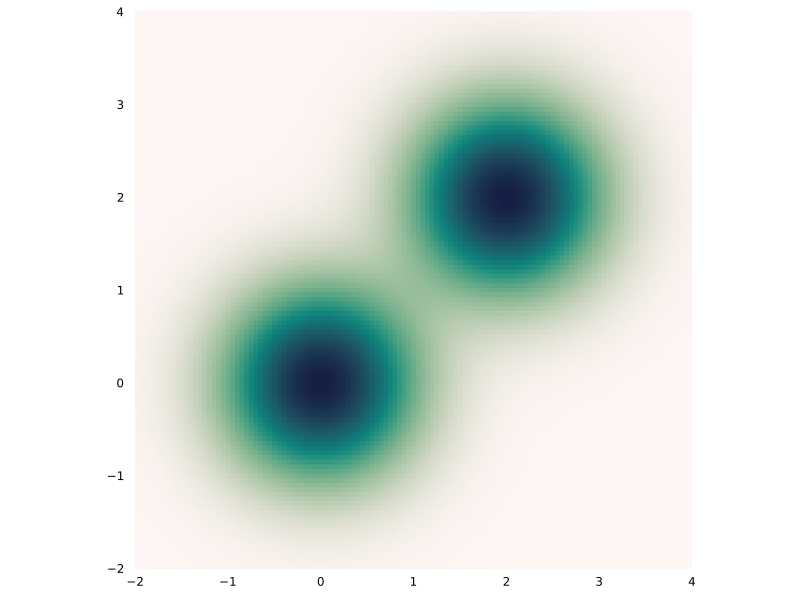

In [44]:
z = rbf.(x_aux, weights=w,centers=mu,sigma2=sigma2)
heatmap(x1_aux,x2_aux,z, aspect_ratio=:equal, c=:tempo, axis=:off, lims=(min(X1_min,X2_min),max(X1_max,X2_max)),colorbar=:none)

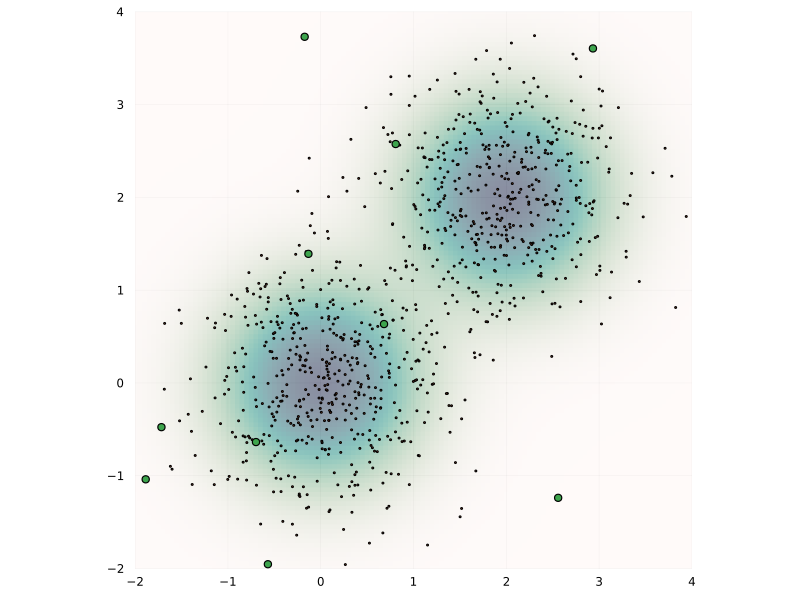

In [51]:
# sample_rbf(N = Sample counts, rbf_func = ,xlims,ylims,cota=2.0)
points = sample_rbf(1000,x->rbf(x,weights=w,centers=mu,sigma2=sigma2),(X1_min,X1_max), (X2_min,X2_max))

heatmap(x1_aux,x2_aux,z, aspect_ratio=:equal, c=:tempo, axis=:off, lims=(min(X1_min,X2_min),max(X1_max,X2_max)),colorbar=:none, alpha=0.5)
scatter!(points, aspect_ratio=:equal, axis=:off, lims=(min(X1_min,X2_min),max(X1_max,X2_max)), label=:none, ms=1)
scatter!(x1,x2, label=:none)

In [75]:
x[10,:]-points[1000]

2-element Point2{Float64} with indices SOneTo(2):
 2.845077543670546
 2.5333688560868057

In [80]:
# Calcular la demanda por sitio
norm = 2
W = [(sum((x[i,:]-points[k]).^norm))^(1/norm) for i=1:s, k=1:1000]; 

attachs = zeros(1000)
for k = 1:1000    
    _,idx = findmin(W[:,k])
    attachs[k] = idx
end
attachs = Int64.(attachs);

#Armar los conjuntos x (celdas de voronoi)
v_i = [ X[findall(x->x==i, attachs),:] for i in 1:s ];
for i=1:s
    println("#v_",i," = ",length(v_i[i]))
end

#v_1 = 6
#v_2 = 26
#v_3 = 356
#v_4 = 34
#v_5 = 0
#v_6 = 176
#v_7 = 626
#v_8 = 480
#v_9 = 26
#v_10 = 270
